# A guide Portfolio Optimization Environment

This notebook aims to provide an example of using PortfolioOptimizationEnv (or POE) to train a reinforcement learning model that learns to solve the portfolio optimization problem.

In this document, we will reproduce a famous architecture called EIIE (ensemble of identical independent evaluators), introduced in the following paper:

- Zhengyao Jiang, Dixing Xu, & Jinjun Liang. (2017). A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem. https://doi.org/10.48550/arXiv.1706.10059.

It's advisable to read it to understand the algorithm implemented in this notebook.

### Note
If you're using this environment, consider citing the following paper (in adittion to FinRL references):

- Caio Costa, & Anna Costa (2023). POE: A General Portfolio Optimization Environment for FinRL. In *Anais do II Brazilian Workshop on Artificial Intelligence in Finance* (pp. 132–143). SBC. https://doi.org/10.5753/bwaif.2023.231144.

```
@inproceedings{bwaif,
 author = {Caio Costa and Anna Costa},
 title = {POE: A General Portfolio Optimization Environment for FinRL},
 booktitle = {Anais do II Brazilian Workshop on Artificial Intelligence in Finance},
 location = {João Pessoa/PB},
 year = {2023},
 keywords = {},
 issn = {0000-0000},
 pages = {132--143},
 publisher = {SBC},
 address = {Porto Alegre, RS, Brasil},
 doi = {10.5753/bwaif.2023.231144},
 url = {https://sol.sbc.org.br/index.php/bwaif/article/view/24959}
}

```

## Installation and imports

To run this notebook in google colab, uncomment the cells below.

In [1]:
## install finrl library
# !sudo apt install swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [2]:
## We also need to install quantstats, because the environment uses it to plot graphs
# !pip install quantstats

In [3]:
## Hide matplotlib warnings
# import warnings
# warnings.filterwarnings('ignore')

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

#### Import the necessary code libraries

In [4]:
import torch

import numpy as np

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.rlportfolio.models import DRLAgent

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Fetch data

In his paper, *Jiang et al* creates a portfolio composed by the top-11 cryptocurrencies based on 30-days volume. Since it's not specified when this classification was done, it's difficult to reproduce, so we will use a similar approach in the Brazillian stock market:

- We select top-10 stocks from Brazillian stock market;
- For simplicity, we disconsider stocks that have missing data for the days in period 2011-01-01 to 2019-12-31 (9 years);

In [5]:
## For some reason, yfinance is not being able to download "LREN3.SA".
TOP_BRL = [
    "VALE3.SA", "PETR4.SA", "ITUB4.SA", "BBDC4.SA",
    "BBAS3.SA", "RENT3.SA", "LREN3.SA", "PRIO3.SA",
    "WEGE3.SA", "ABEV3.SA"
]

## So we changed it to VIVT3.SA, another high-volume stock.
# TOP_BRL = [
#     "VALE3.SA", "PETR4.SA", "ITUB4.SA", "BBDC4.SA",
#     "BBAS3.SA", "RENT3.SA", "VIVT3.SA", "PRIO3.SA",
#     "WEGE3.SA", "ABEV3.SA"
# ]

In [6]:
print(len(TOP_BRL))

portfolio_raw_df = YahooDownloader(start_date = '2011-01-01',
                                end_date = '2022-12-31',
                                ticker_list = TOP_BRL).fetch_data()
portfolio_raw_df

10


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (29780, 8)


,date,open,high,low,close,volume,tic,day
0,2011-01-03,5.287134,8.690246,8.728203,8.632311,576145,ABEV3.SA,0
1,2011-01-03,6.253509,15.700000,15.900000,15.750000,6626800,BBAS3.SA,0
2,2011-01-03,6.345205,11.774127,11.927362,11.809763,10862336,BBDC4.SA,0
3,2011-01-03,10.442616,18.067982,18.250118,18.031555,10014663,ITUB4.SA,0
4,2011-01-03,6.173821,8.510648,8.629907,8.422694,3652542,LREN3.SA,0
...,...,...,...,...,...,...,...,...
29775,2022-12-29,16.668446,24.500000,25.049999,24.990000,57901800,PETR4.SA,3
29776,2022-12-29,37.150330,37.209999,37.480000,37.250000,7890300,PRIO3.SA,3
29777,2022-12-29,50.361664,53.025078,55.776001,54.300869,8786791,RENT3.SA,3
29778,2022-12-29,77.194092,88.879997,89.949997,89.000000,40110800,VALE3.SA,3


In [7]:
portfolio_raw_df.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
ABEV3.SA,2978,2978,2978,2978,2978,2978,2978
BBAS3.SA,2978,2978,2978,2978,2978,2978,2978
BBDC4.SA,2978,2978,2978,2978,2978,2978,2978
ITUB4.SA,2978,2978,2978,2978,2978,2978,2978
LREN3.SA,2978,2978,2978,2978,2978,2978,2978
PETR4.SA,2978,2978,2978,2978,2978,2978,2978
PRIO3.SA,2978,2978,2978,2978,2978,2978,2978
RENT3.SA,2978,2978,2978,2978,2978,2978,2978
VALE3.SA,2978,2978,2978,2978,2978,2978,2978


In [8]:
import pandas as pd

df_portfolio = portfolio_raw_df[["date", "tic", "close", "high", "low"]]

df_portfolio_train = df_portfolio[(df_portfolio["date"] >= "2011-01-01") & (df_portfolio["date"] < "2019-12-31")]
df_portfolio_2020 = df_portfolio[(df_portfolio["date"] >= "2020-01-01") & (df_portfolio["date"] < "2020-12-31")]
df_portfolio_2021 = df_portfolio[(df_portfolio["date"] >= "2021-01-01") & (df_portfolio["date"] < "2021-12-31")]
df_portfolio_2022 = df_portfolio[(df_portfolio["date"] >= "2022-01-01") & (df_portfolio["date"] < "2022-12-31")]

### Instantiate Environment

Using the `PortfolioOptimizationEnv`, it's easy to instantiate a portfolio optimization environment for reinforcement learning agents. In the example below, we use the dataframe created before to start an environment.

In [9]:
environment = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        state_normalization="by_last_close",
        comission_fee_pct=0.0025,
        time_window=50,
        time_format="%Y-%m-%d",
        features=["close", "high", "low"],
        print_metrics=False,
        plot_graphs=False
    )

### Instantiate Model

Now, we can instantiate the model using FinRL API. In this example, we are going to use the EIIE architecture introduced by Jiang et. al.

:exclamation: **Note:** Remember to set the policy's `time_window` parameter with the same value of the environment's `time_window`.

In [10]:
# set PolicyGradient parameters
model_kwargs = {
    "lr": 5e-5,
    "sample_bias": 0.001,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "time_window": 50,
}

model = DRLAgent(environment).get_model("pg", "eiie", model_kwargs, policy_kwargs, device)

### Train Model

In [11]:
# DRLAgent.train_model(model, 100000, logging_period=10000)

### Save Model

In [12]:
# torch.save(model.train_policy.state_dict(), "policy_EIIE.pt")

## Test Model

### Instantiate different environments

Since we have three different periods of time, we need three different environments instantiated to simulate them.

In [13]:
environment_2020 = PortfolioOptimizationEnv(
    df_portfolio_2020,
    initial_amount=100000,
    state_normalization="by_last_close",
    comission_fee_pct=0.0025,
    time_window=50,
    time_format="%Y-%m-%d",
    features=["close", "high", "low"],
    print_metrics=False,
    plot_graphs=True
)

environment_2021 = PortfolioOptimizationEnv(
    df_portfolio_2021,
    initial_amount=100000,
    state_normalization="by_last_close",
    comission_fee_pct=0.0025,
    time_window=50,
    time_format="%Y-%m-%d",
    features=["close", "high", "low"],
    print_metrics=False,
    plot_graphs=False
)

environment_2022 = PortfolioOptimizationEnv(
    df_portfolio_2022,
    initial_amount=100000,
    state_normalization="by_last_close",
    comission_fee_pct=0.0025,
    comission_fee_model="trf_approx",
    time_window=50,
    time_format="%Y-%m-%d",
    features=["close", "high", "low"],
    print_metrics=False,
    plot_graphs=True
)

### Test Uniform Buy and Hold
For comparison, we will also test the performance of a uniform buy and hold strategy. In this strategy, the portfolio has no remaining cash and the same percentage of money is allocated in each asset.

In [14]:
UBAH_results = {
    "train": {},
    "2020": {},
    "2021": {},
    "2022": {}
}

PORTFOLIO_SIZE = len(TOP_BRL)

# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _, _ = environment.step(action)
UBAH_results["train"]["value"] = environment._asset_memory["final"]

# 2020
terminated = False
environment_2020.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _, _ = environment_2020.step(action)
UBAH_results["2020"]["value"] = environment_2020._asset_memory["final"]

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _, _ = environment_2021.step(action)
UBAH_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _, _ = environment_2022.step(action)
UBAH_results["2022"]["value"] = environment_2022._asset_memory["final"]

### Test EIIE architecture
Now, we can test the EIIE architecture in the three different test periods. It's important no note that, in this code, we load the saved policy even though it's not necessary just to show how to save and load your model.

In [15]:
EIIE_results = {
    "training": [],
    "2020": {},
    "2021": {},
    "2022": {}
}

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
from rlportfolio.policy import EIIE

policy = EIIE(time_window=50, device=device)
policy.load_state_dict(torch.load("policy_EIIE.pt"))

# training
DRLAgent.DRL_validation(model, environment, policy=policy)
EIIE_results["training"] = environment._asset_memory["final"]

# 2020
DRLAgent.DRL_validation(model, environment_2020, policy=policy)
EIIE_results["2020"]["value"] = environment_2020._asset_memory["final"]

# 2021
DRLAgent.DRL_validation(model, environment_2021, policy=policy)
EIIE_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
DRLAgent.DRL_validation(model, environment_2022, policy=policy)
EIIE_results["2022"]["value"] = environment_2022._asset_memory["final"]

/tmp/ipykernel_12771/2904081508.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load("policy_EIIE.pt"))


### Plot graphics

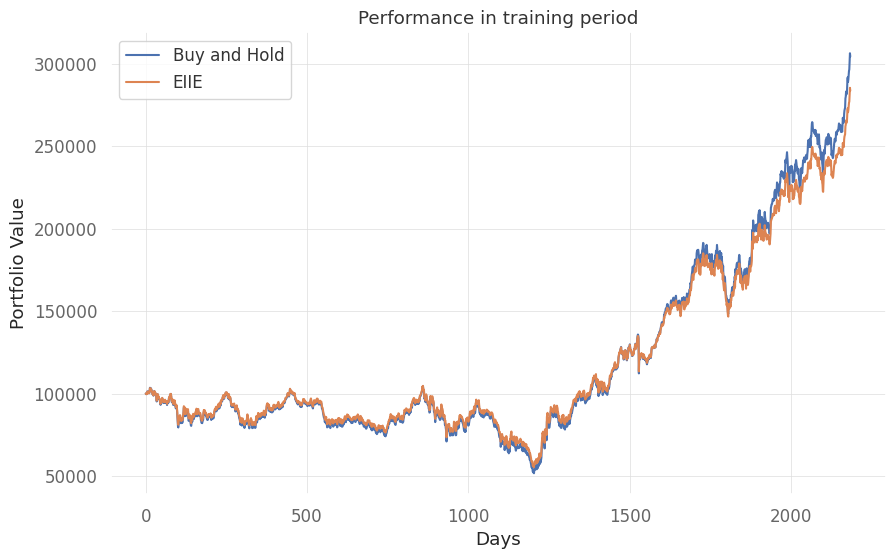

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["training"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

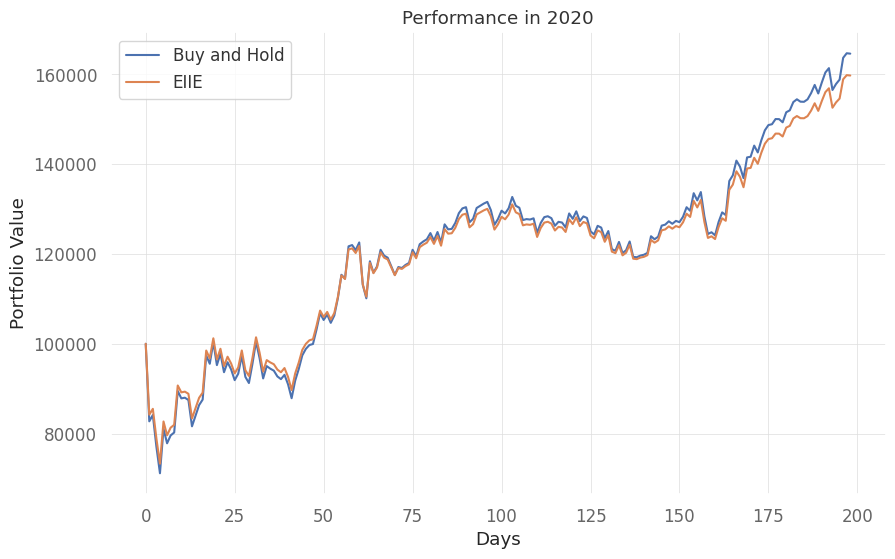

In [17]:
plt.plot(UBAH_results["2020"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2020"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2020")
plt.legend()

plt.show()

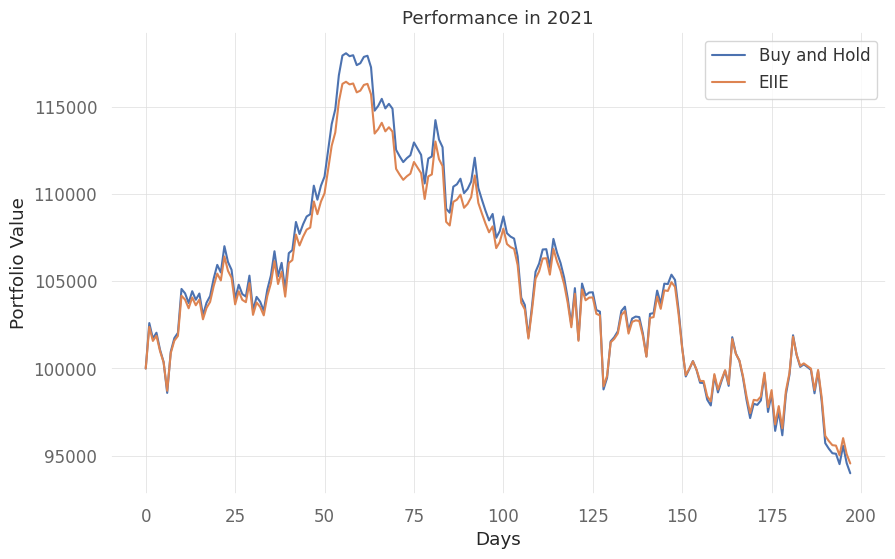

In [18]:
plt.plot(UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2021"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

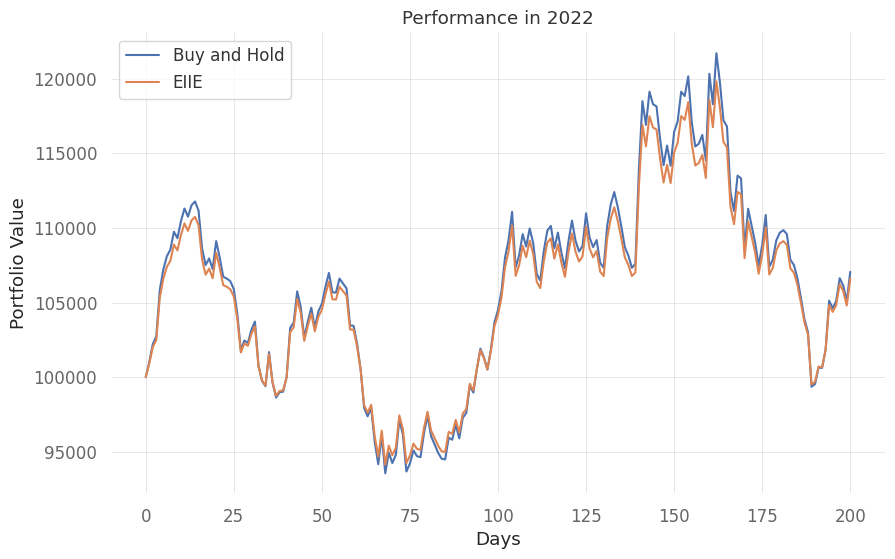

In [19]:
plt.plot(UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2022"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()

We can see that the agent is able to learn a good policy but its performance is worse the more the test period advances into the future. To get a better performance in 2022, for example, the agent should probably be trained again using more recent data.

In [20]:
import matplotlib.pyplot as plt
environment_2020._final_weights

[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0.09912647, 0.09924631, 0.09209252, 0.0953405 , 0.09505875,
        0.08293378, 0.09484114, 0.07435937, 0.0851741 , 0.09272089,
        0.08910615], dtype=float32),
 array([0.08336878, 0.08840375, 0.09445866, 0.09141709, 0.09538157,
        0.08811154, 0.09737954, 0.09757687, 0.08429307, 0.10141443,
        0.07819482], dtype=float32),
 array([0.08953503, 0.09661657, 0.09328216, 0.09767012, 0.09757514,
        0.08812912, 0.08849496, 0.08027897, 0.08722616, 0.09501632,
        0.08617551], dtype=float32),
 array([0.08891525, 0.1002111 , 0.08583087, 0.0902245 , 0.09298683,
        0.08369261, 0.09581061, 0.08524702, 0.08706722, 0.09510463,
        0.09490938], dtype=float32),
 array([0.07325979, 0.09007368, 0.08568513, 0.08682788, 0.08247361,
        0.10087945, 0.09867587, 0.10699242, 0.09963245, 0.08219279,
        0.09330702], dtype=float32),
 array([0.0851527 , 0.09785782, 0.08824033, 0.08567142, 0.0895198 